In [59]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
from pandas.tools.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import tools as t
from matplotlib.colors import LogNorm, SymLogNorm, BoundaryNorm, Normalize
import glob
import pymses
from pymses.utils import constants as C
import seaborn as sns

from scipy.stats import binned_statistic, binned_statistic_2d, binned_statistic_dd

import os, sys
import sh

import astropy
from astroML import correlation

#plt.rcParams['figure.figsize'] = (23, 23*10./16.)
f = 0.7
plt.rcParams['figure.figsize'] = (23*f, 23*10./16*f)
plt.rcParams['figure.dpi'] = 72
matplotlib.style.use(['ggplot'])
#matplotlib.style.use(['bmh'])
#matplotlib.style.use(['fivethirtyeight'])

In [3]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    "Skip the cell if activate"
    print('Cell skipped.')
    pass

## modulemagic - IPython Notebook cell magic %%module
# Gordon Bean, April 2015

from IPython.core.magic import Magics, magics_class, cell_magic
import os, sys, importlib, argparse, tempfile

## Functions for loading the extension
def load_ipython_extension(ipython):
    ipython.register_magics(ModuleMagics)
    
@magics_class
class ModuleMagics(Magics):
    '''Magics for creating modules in IPython.'''
    
    def __init__(self, shell=None, namespace=None):
        if shell is None:
            shell = get_ipython()
            
        super(ModuleMagics, self).__init__(shell)
        
        self.namespace = namespace
        
        # Get the kernel id
        self.kernelID = os.path.basename(shell.kernel.config['IPKernelApp']['connection_file'])[:-5]
        
        # Create kernel-specific tmp-module directory
        self.module_dir = tempfile.mkdtemp(self.kernelID)
        if not os.path.exists(self.module_dir):
            os.makedirs(self.module_dir)
    
    def __del__(self):
        # Remove module_dir from file system and sys.path
        # I'm not sure this works - evidence so far says no...
        tmpfiles = os.listdir(self.module_dir)
        for file in tmpfiles:
            os.remove(os.path.join(self.module_dir, file))
            
        os.rmdir(self.module_dir)
        
        sys.path.remove(self.module_dir)
    
    @cell_magic
    def module(self, line, cell):
        '''Import the cell as a module.'''
        # Parse the parameters
        parser = argparse.ArgumentParser('%%module cell magic')
        parser.add_argument('name')
        parser.add_argument('-p','--path', default=self.module_dir)
        args = parser.parse_args(line.split())
        
        name = args.name
        
        # Save to file
        if not os.path.exists(args.path):
            os.makedirs(args.path)
            
        filename = os.path.join(args.path, name + '.py')
        with open(filename, 'w') as f:
            f.write(cell)

        # Import module
        if args.path not in sys.path:
            sys.path.insert(0, args.path)

        if name in sys.modules:
            # Always reload
            del sys.modules[name]

        module = importlib.import_module(name)
        
        if self.namespace:
            self.namespace[name] = module
        else:
            self.shell.push({name: module})

        return module
load_ipython_extension(get_ipython())

In [39]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
%autoreload

# Chargement données

In [7]:
halo_list = pd.read_csv('lists/list_halo.dat',
                        delim_whitespace=True,
                        skiprows=1,
                        names=['id', 'level', 'mass', 'x', 'y', 'z', 'r']).set_index('id')


In [8]:
unit, ncol, nrow = t.io.read_list_header('lists/list_kingal_00782.dat')
gal_dynamics = pd.DataFrame(t.io.read_list_data_reals(unit, ncol, nrow),
                            columns=['id', 'vtheta', 'dvx', 'dvy', 'dvz', 'mass', 'x', 'y', 'z']).set_index('id')

gd = gal_dynamics
gal_dynamics['sigma_over_vtheta'] = 1./3*np.sqrt((gd.dvx**2 + gd.dvy**2 + gd.dvz**2)) / np.abs(gd.vtheta)
del gd

In [9]:
association = pd.read_csv('lists/associated_halogal_782.dat', delim_whitespace=True, skiprows=1,
                          names=['halo_id', 'level', 'halo_mass', 'gal_id', 'gal_mass']).set_index('halo_id')

In [16]:
halos = t.io.read_brick('/data52/Horizon-AGN/TREE_DM_celldx2kpc_SC0.9r/tree_bricks782', low_mem=['nparts', 'members', 'idh', 'hlevel'])
l = list(tqdm(halos.it))
halos_props = pd.DataFrame([{'hlevel': h['hlevel'], 'idh':h['idh'][0], 'nparts': h['nparts'][0]} for h in l]).set_index('idh')
halo_members = [{'idh': h['idh'][0], 'members': h['members']} for h in l]
del l

In [11]:
inertia_data = pd.read_csv('data/halo_kin.00002.1e10_m.dat', delim_whitespace=True, dtype=np.float,
                           engine='c', index_col=0)

print('Found {} halo.'.format(inertia_data['mass'].size))


Found 280219 halo.


In [12]:
def get_sov():
    halo_with_galaxy = set(association.index)
    inertia_data_halos = set(inertia_data.index)
    common = halo_with_galaxy.intersection(inertia_data_halos)
    gal_ids = association.loc[common, 'gal_id'].as_matrix()
    sov = gal_dynamics.loc[gal_ids, 'sigma_over_vtheta'].as_matrix()
    return common, sov
ids, sov = get_sov()

inertia_data['host_gal'] = False
inertia_data.loc[ids, 'sigma_over_vtheta'] = sov
inertia_data.loc[ids, 'host_gal'] = True

In [13]:
%%cython
cimport numpy as np
import numpy as np
cimport cython

@cython.boundscheck(False)
cdef np.ndarray[double, ndim=2] cy_compute_tensor(np.ndarray[double, ndim=1] xx, np.ndarray[double, ndim=1] xy, 
                   np.ndarray[double, ndim=1] xz, np.ndarray[double, ndim=1] yy,
                   np.ndarray[double, ndim=1] yz, np.ndarray[double, ndim=1] zz, tqdm):
    cdef int i, j
    cdef np.ndarray[double, ndim=2] I
    cdef np.ndarray[double, ndim=2] eva = np.zeros((len(xx), 3))
    cdef np.ndarray[double, ndim=1] tmp

    for i in tqdm(range(len(xx))):
        I = np.zeros((3, 3))
        I[0,0] = xx[i]
        I[0,1] = xy[i]
        I[1,0] = xy[i]
        I[0,2] = xz[i]
        I[2,0] = xz[i]
        I[1,1] = yy[i]
        I[1,2] = yz[i]
        I[2,1] = yz[i]
        I[2,2] = zz[i]

        tmp = np.linalg.eigvalsh(I)
        for j in range(3):
            eva[i, j] = tmp[j]
    return eva

def compute_tensor(d, tqdm=None):
    cdef np.ndarray[double, ndim=1] xx, xy, xz, yy, yz, zz 
    xx, xy, xz, yy, yz, zz = np.array([d['xx'], d['xy'], d['xz'], d['yy'], d['yz'], d['zz']], dtype=np.float)
    if tqdm == None:
        tqdm = lambda i: i
    return cy_compute_tensor(xx, xy, xz, yy, yz, zz, tqdm)


In [14]:
eva = compute_tensor(inertia_data, tqdm=tqdm)

In [17]:
inertia_data['l0'] = np.sqrt(eva[:, 0])
inertia_data['l1'] = np.sqrt(eva[:, 1])
inertia_data['l2'] = np.sqrt(eva[:, 2])
inertia_data[['log(mass)', 'log(l0)', 'log(l1)', 'log(l2)', 'log(sigma_over_vtheta)']] = (
    np.log10(inertia_data[['mass', 'l0', 'l1', 'l2', 'sigma_over_vtheta']])
    )

In [18]:
to_set = set(inertia_data.index)
from_set = set(halos_props.index)

inter = list(to_set.intersection(from_set))
inertia_data.loc[inter, 'hlevel'] = halos_props.loc[inter, 'hlevel']


In [19]:
inertia_data['prolateness'] = inertia_data.eval('l2/sqrt(l1*l0)')
inertia_data['log(prolateness)'] = np.log10(inertia_data['prolateness'])

inertia_data['oblateness'] = inertia_data.eval('sqrt(l2*l1)/l0')
inertia_data['log(oblateness)'] = np.log10(inertia_data['oblateness'])

inertia_data['prod_li'] = inertia_data.eval('l2*l1*l0')
inertia_data['log(prod_li)'] = np.log10(inertia_data['prod_li'])

In [20]:
bins = [0, 0.5, 1.5, np.infty]
labels = ['elliptical', 'intermediate', 'spiral']
inertia_data['vtheta_over_sigma'] = 1./inertia_data['sigma_over_vtheta']
inertia_data['galaxy_type'] = pd.cut(inertia_data['vtheta_over_sigma'], bins, labels=labels)
inertia_data['log(mass/prod_li)'] = inertia_data['log(mass)'] - inertia_data['log(prod_li)']

In [21]:
RamsesOutput = pymses.RamsesOutput('/data52/Horizon-AGN/OUTPUT_DIR/', 2)

Computing hilbert minimal domain description for output 2 ...
Done !


In [23]:
%%skip
del halos_props, halos, halo_members

Cell skipped.


# Diagramme volume-mass

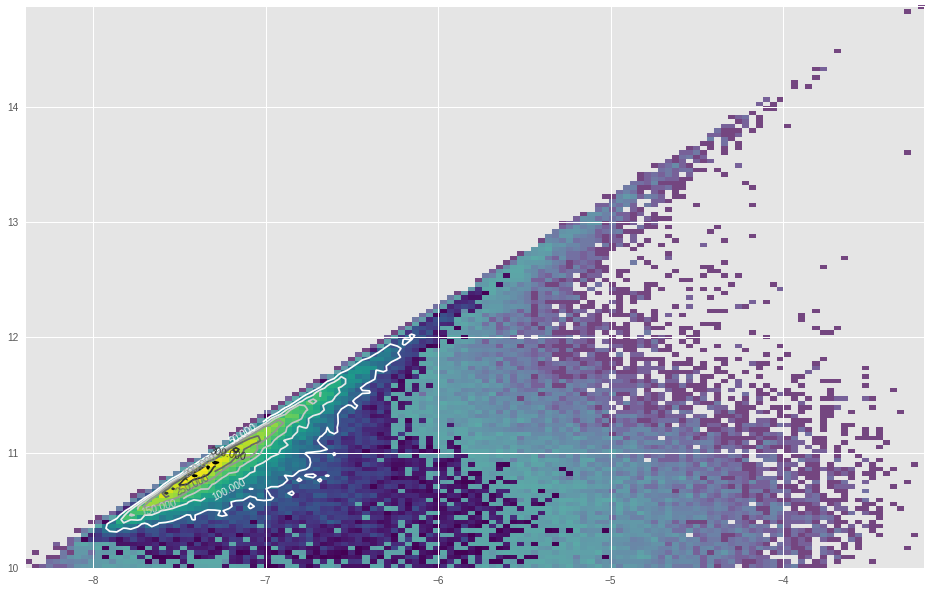

In [24]:
fig, ax = plt.subplots()

mask = inertia_data['host_gal'] == True
counts, xe, ye , img = ax.hist2d('log(prod_li)', 'log(mass)', data=inertia_data[mask], bins=128, norm=LogNorm(), cmap='viridis', cmin=1, alpha=0.7)
ax.hist2d('log(prod_li)', 'log(mass)', data=inertia_data[mask], bins=128, norm=LogNorm(), cmap='viridis', cmin=20)
CS = ax.contour(xe[1:], ye[1:], counts.T)
_ = ax.clabel(CS)


/home/cadiou/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/cadiou/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


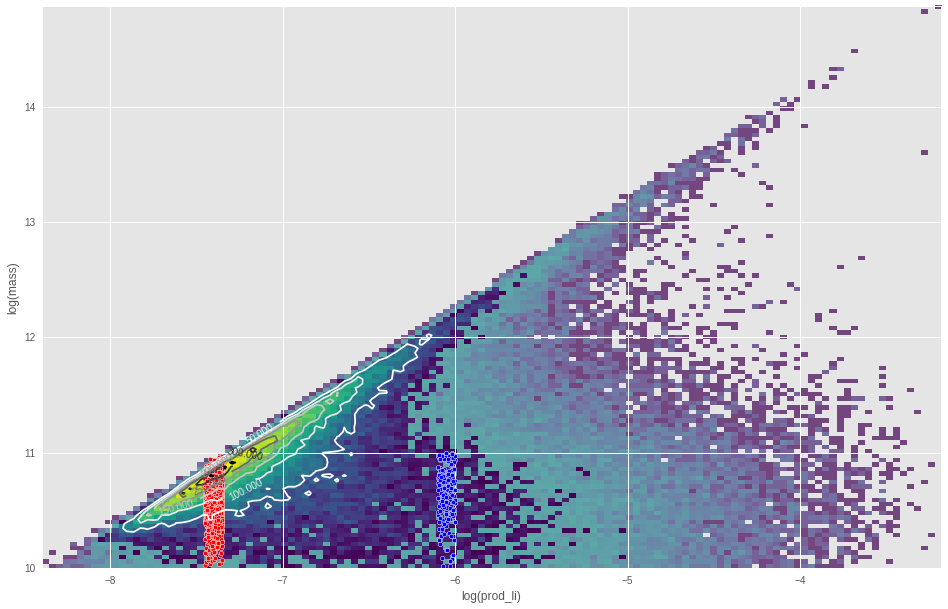

In [42]:
fig, ax = plt.subplots()

mask = inertia_data['host_gal'] == True
counts, xe, ye , img = ax.hist2d('log(prod_li)', 'log(mass)', data=inertia_data[mask], bins=128, norm=LogNorm(), cmap='viridis', cmin=1, alpha=0.7)
ax.hist2d('log(prod_li)', 'log(mass)', data=inertia_data[mask], bins=128, norm=LogNorm(), cmap='viridis', cmin=20)
CS = ax.contour(xe[1:], ye[1:], counts.T)
_ = ax.clabel(CS)

tmp = inertia_data[mask][inertia_data['log(mass)'] >= 10][inertia_data['log(mass)'] < 11][inertia_data['log(prod_li)'] > -6.1][inertia_data['log(prod_li)'] < -6][inertia_data.hlevel == 1]
tmp.plot.scatter('log(prod_li)', 'log(mass)', ax=ax, c='blue')

tmp = inertia_data[mask][inertia_data['log(mass)'] >= 10][inertia_data['log(mass)'] < 11][inertia_data['log(prod_li)'] > -7.45][inertia_data['log(prod_li)'] < -7.35][inertia_data.hlevel == 1]
tmp.plot.scatter('log(prod_li)', 'log(mass)', ax=ax, c='red')

## Halos aléatoires, de niveau 1 en "bas à droite"
En bas à droite signifie $\log \prod_i \lambda_i \in \left[-6.1; -6\right]$ et $m \in \left[10^{10}; 10^{11}\right] M_\odot$
Les halos 89315, 224391,  62593, 109305, 44184, 36115, 48358, 79144, 166877, 200633, 131698, 58254, 158174, 193472, 82199 en sont un exemple (au hasard)

In [146]:
#ids = tmp.index[np.random.randint(0, len(tmp.index), size=10)]
#ids = np.array(ids, dtype=int)
ids = np.array([ 89315, 224391,  62593, 109305,  44184, 36115,  48358,  79144, 166877, 200633, 131698,  58254, 158174, 193472,  82199])
ids

array([ 89315, 224391,  62593, 109305,  44184,  36115,  48358,  79144,
       166877, 200633, 131698,  58254, 158174, 193472,  82199])

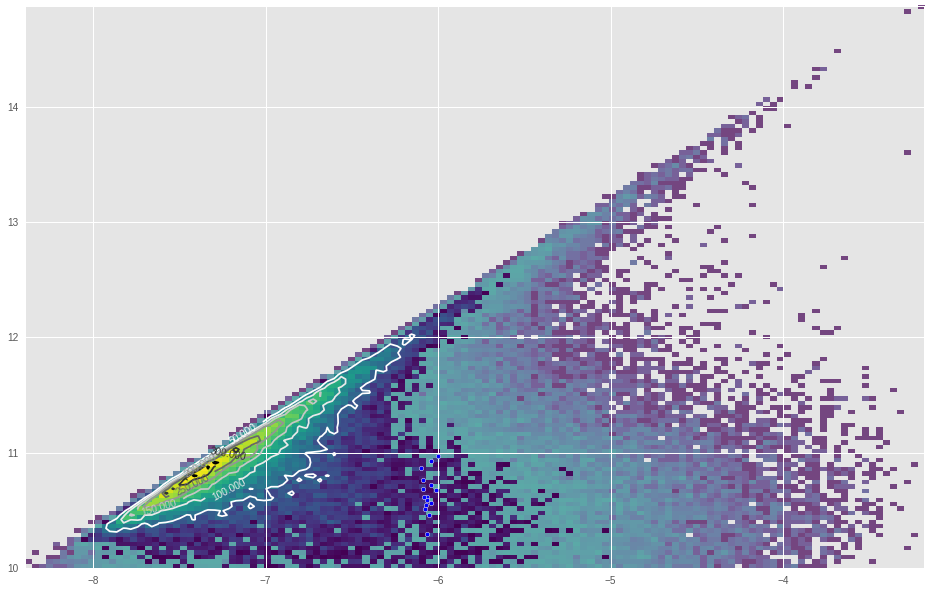

In [37]:
fig, ax = plt.subplots()

mask = inertia_data['host_gal'] == True
counts, xe, ye , img = ax.hist2d('log(prod_li)', 'log(mass)', data=inertia_data[mask], bins=128, norm=LogNorm(), cmap='viridis', cmin=1, alpha=0.7)
ax.hist2d('log(prod_li)', 'log(mass)', data=inertia_data[mask], bins=128, norm=LogNorm(), cmap='viridis', cmin=20)
CS = ax.contour(xe[1:], ye[1:], counts.T)
_ = ax.clabel(CS)

ax.scatter('log(prod_li)', 'log(mass)', data=inertia_data.loc[ids], c='blue', legend='Diffuse')

In [147]:
df = pd.DataFrame()
for i in ids:
    tmp_df = pd.read_csv('data/halo_%i-00002' % i, delim_whitespace=True, engine='c', dtype={'x': np.float64, 'y': np.float64, 'z': np.float64, 'id': int})
    tmp_df['halo'] = i
    df = df.append(tmp_df)
    del tmp_df

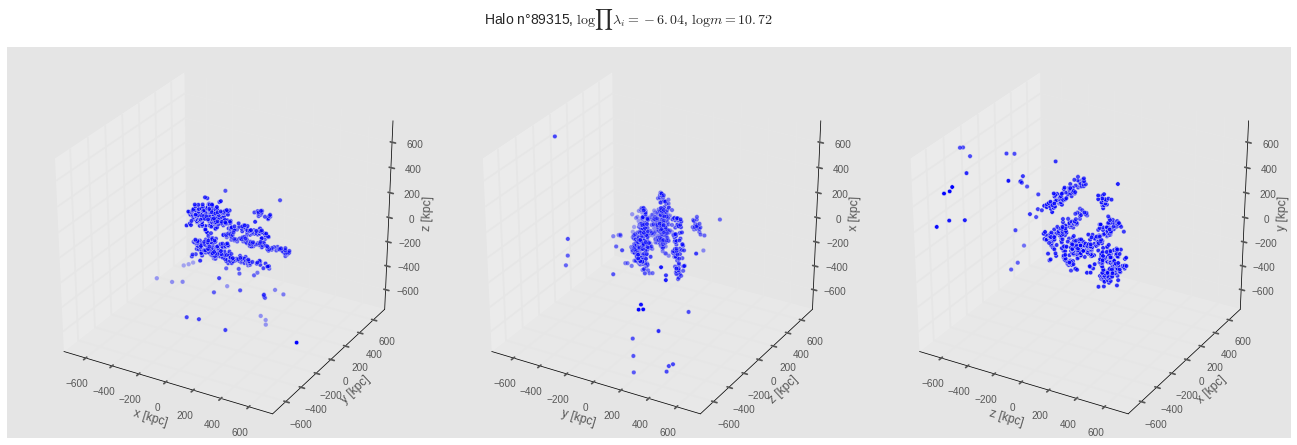

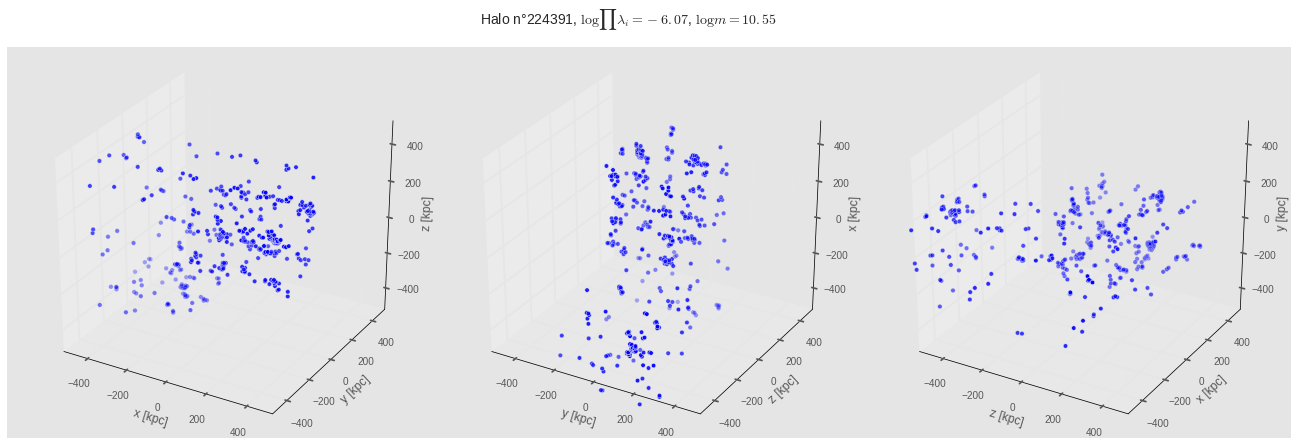

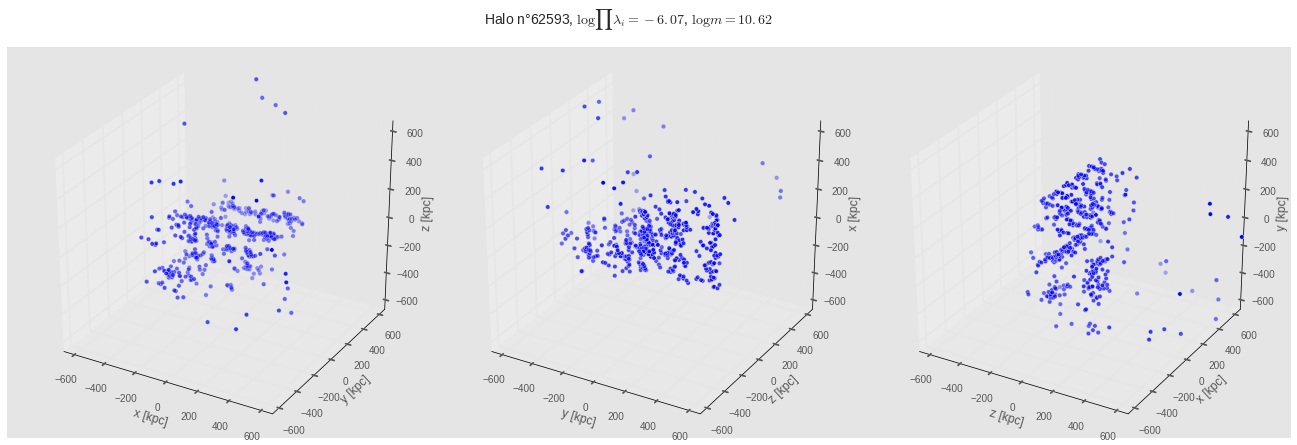

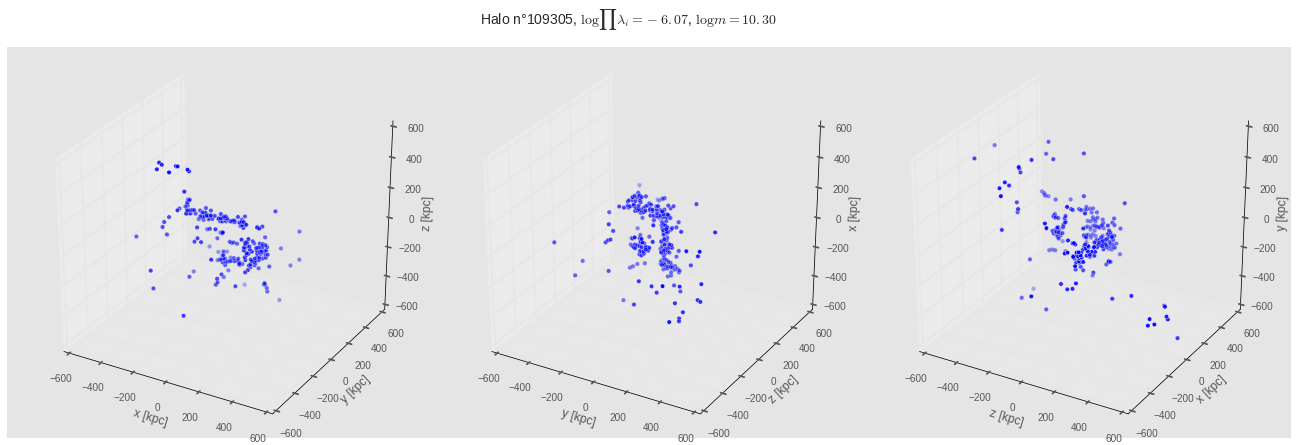

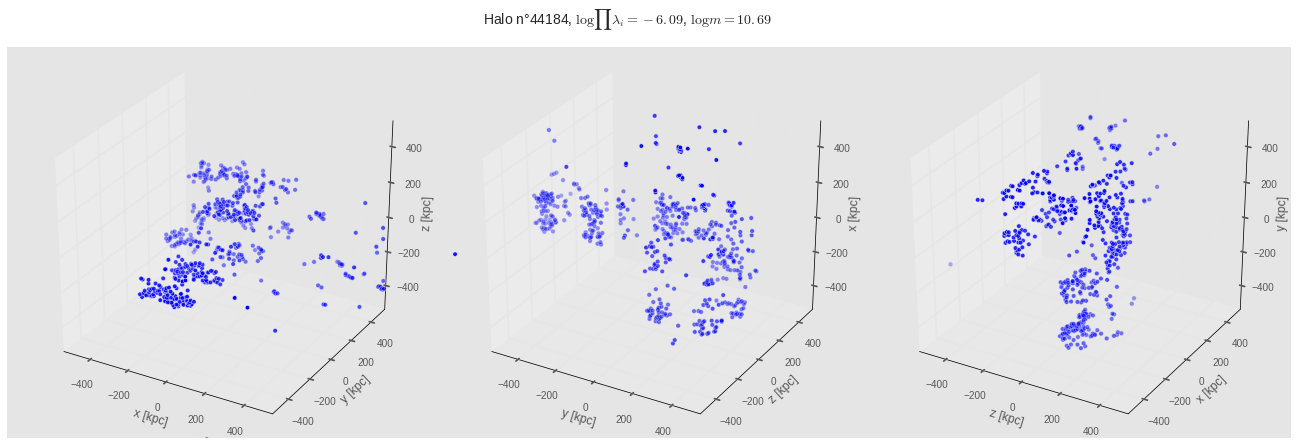

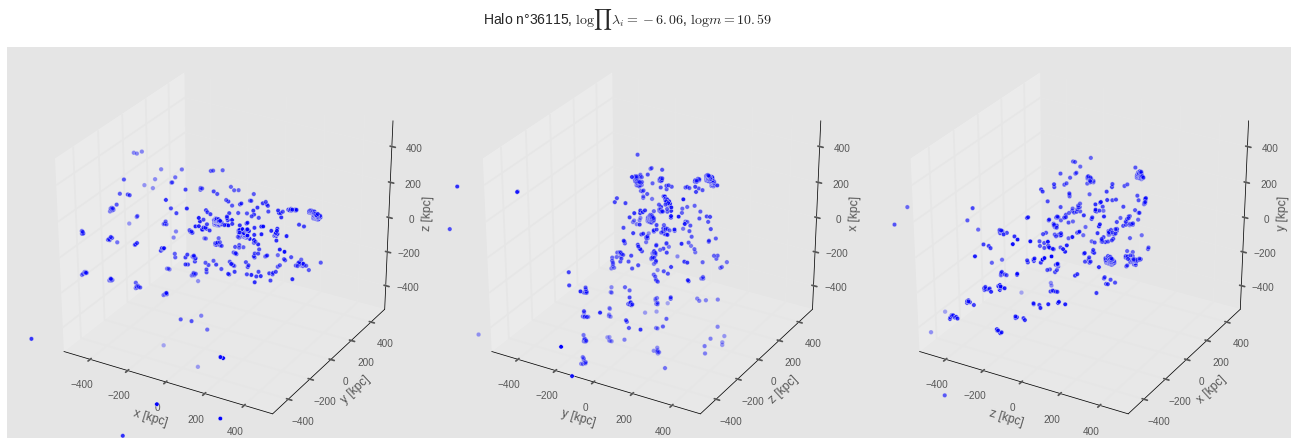

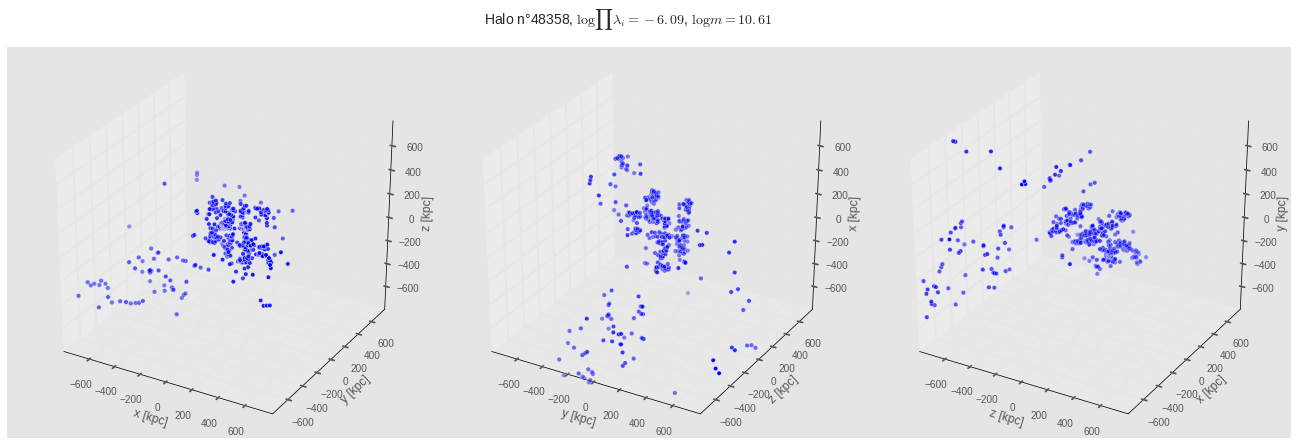

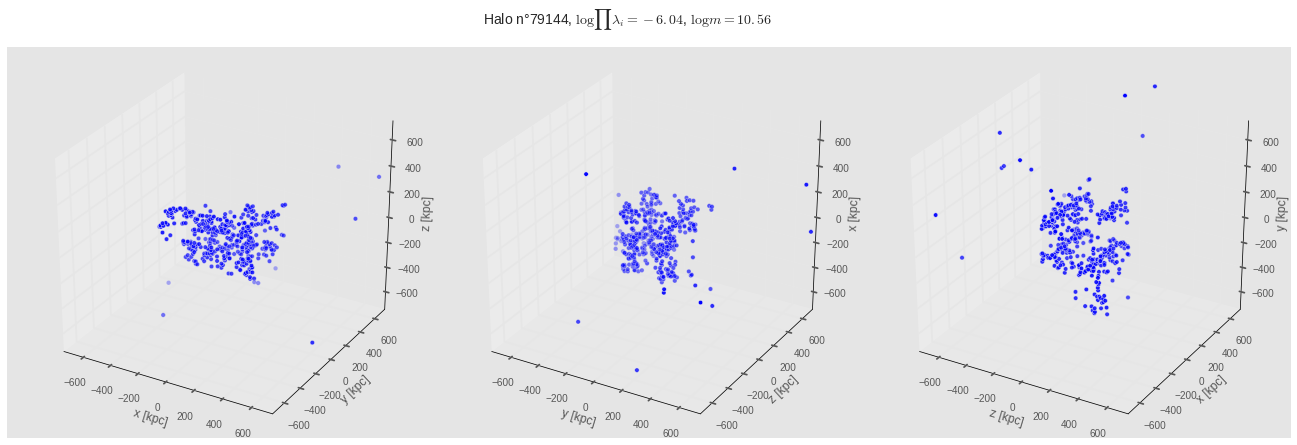

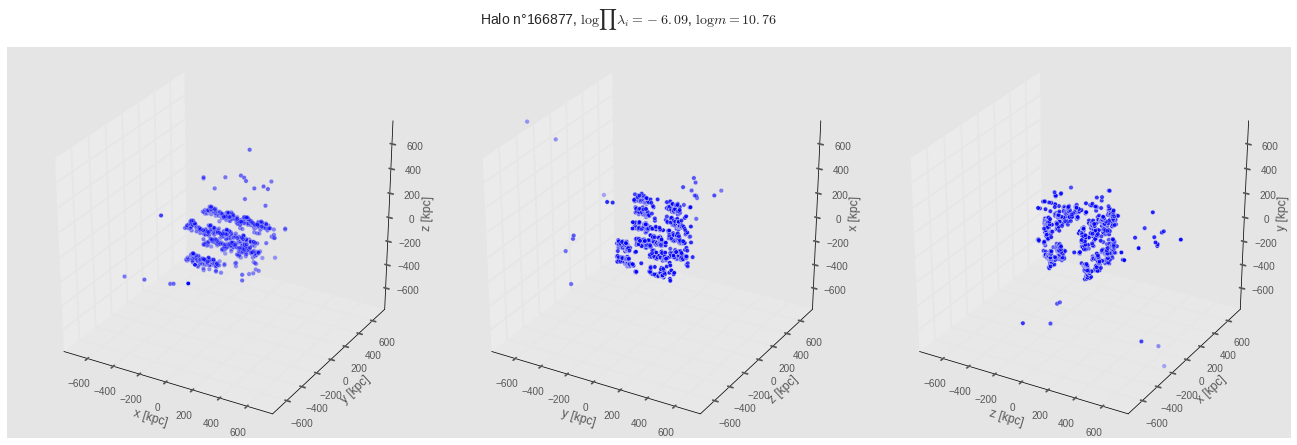

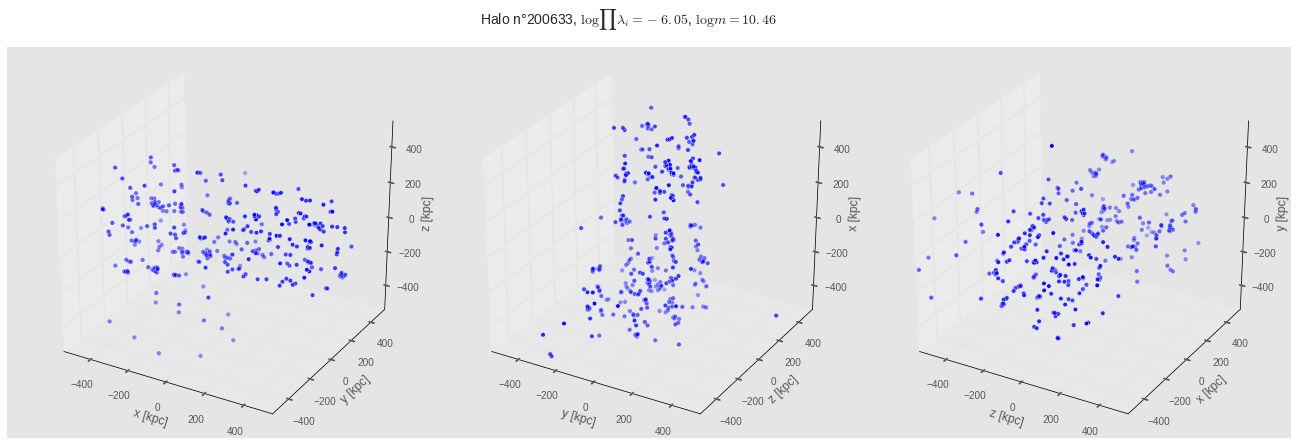

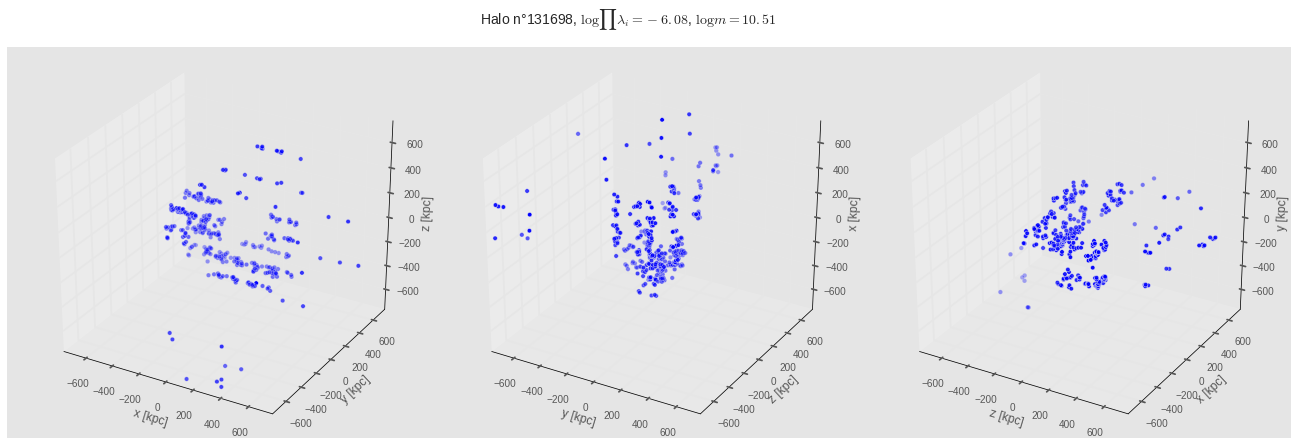

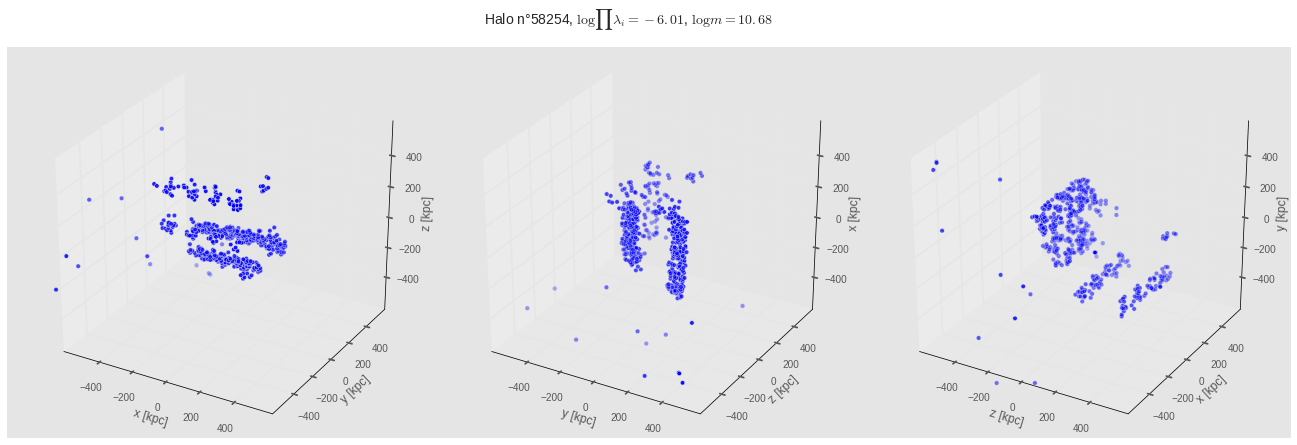

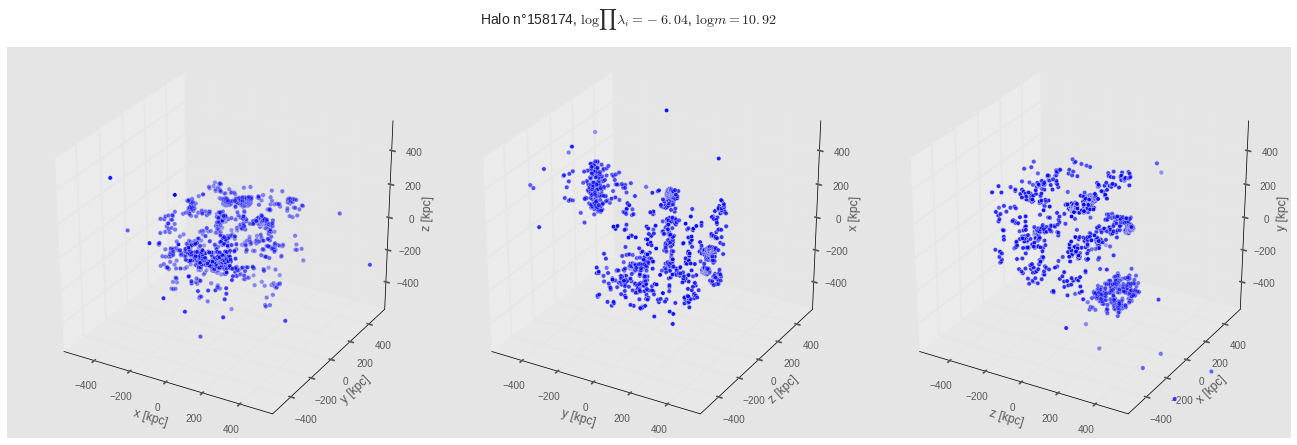

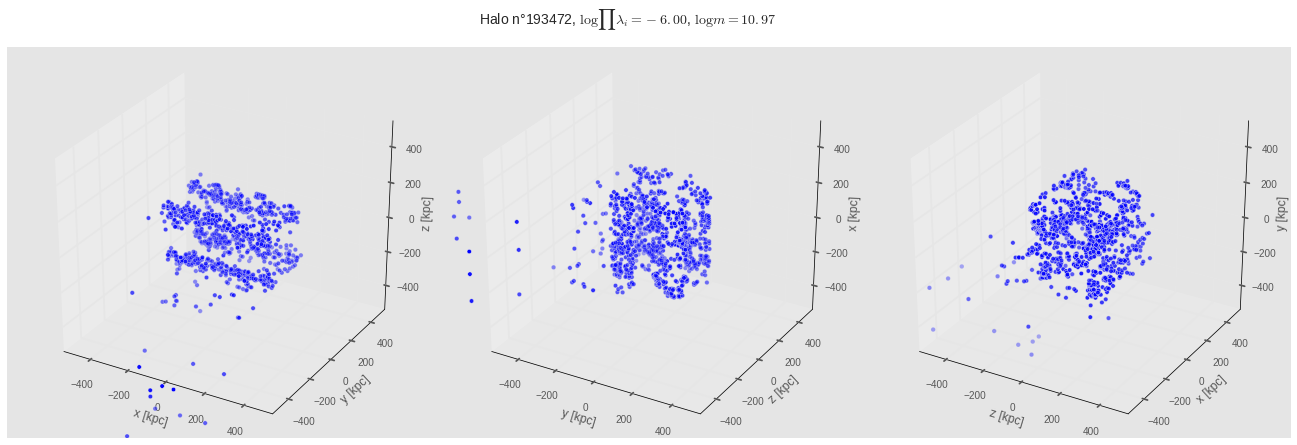

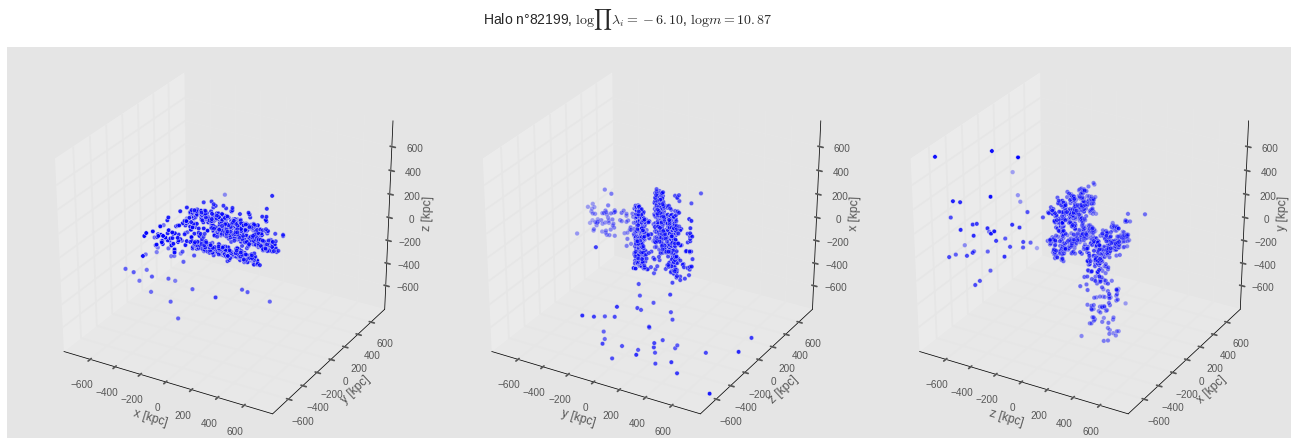

In [148]:
toKpc = RamsesOutput.info['unit_length'].express(C.kpc)
for i in ids:
    fig = plt.figure(figsize=(23, 23/3))
    
    mean = df.loc[df.halo==i, ['x', 'y', 'z']].mean()
    span = np.max(df[df.halo==i][['x', 'y', 'z']].max() - df[df.halo==i][['x', 'y', 'z']].min()) / 2
    
    corr = pd.DataFrame({'x': df.loc[df.halo == i, 'x'] - mean[0],
                         'y': df.loc[df.halo == i, 'y'] - mean[1],
                         'z': df.loc[df.halo == i, 'z'] - mean[2],
                        })
    
    for j, (x,y,z) in enumerate([['x', 'y', 'z'], ['y', 'z', 'x'], ['z', 'x', 'y']]):
        ax = fig.add_subplot(1,3,j+1, projection='3d')
    
        ax.scatter3D(corr[x]*toKpc, corr[y]*toKpc, corr[z]*toKpc)
        fig.suptitle(u'Halo n°%i, $\log \prod \lambda_i = %.2f$, $\log m = %.2f$' % (i, inertia_data.loc[i, 'log(prod_li)'], inertia_data.loc[i, 'log(mass)']), fontsize=14)
        
        ax.set_xlabel('%s [kpc]' % x)
        ax.set_ylabel('%s [kpc]' % y)
        ax.set_zlabel('%s [kpc]' % z)
        
        ax.set_xlim(-span*toKpc, span*toKpc)
        ax.set_ylim(-span*toKpc, span*toKpc)
        ax.set_zlim(-span*toKpc, span*toKpc)
    plt.subplots_adjust(wspace=0, hspace=0)

## Halos aléatoires, de niveau 1 dans la zone dense
Par exemple 
- pour un halo de masse $10^{10} \leq m < 10^{11}$, $-7.45 \leq \prod \lambda_i < -7.35$:

    ```43410,  29329,  73716, 131332,  30762,  83755,  12373, 153126, 13543, 125486```
    
    
- pour un halo tel que $\log(m) - \log\prod\lambda_i > 18.1$, avec une galaxie et de niveau 1:

    ```111566 50190 209456 53895 95489 222471 62287 131777 26848 145638```
    
- pour un halo tel que $\log(m) - \log\prod\lambda_i > 18.1$, avec une galaxie et de niveau 1, $\log m > 10^{11}$:

    ```156537 171572 37994 119957 150368 26226 111873 85789 74552 201204```

In [25]:
#tmp = inertia_data[inertia_data['log(mass/prod_li)'] > 18.][inertia_data.hlevel == 1][inertia_data.host_gal == True][inertia_data['log(mass)'] > 11]
#ids = np.array(tmp.index[np.random.randint(0, len(tmp.index), size=10)], dtype=int)

#tmp = inertia_data[mask][inertia_data['log(mass)'] >= 10][inertia_data['log(mass)'] < 11][inertia_data['log(prod_li)'] > -7.45][inertia_data['log(prod_li)'] < -7.35][inertia_data.hlevel == 1]

# # 10 < log m < 11, prod_li in -7.45, -7.35
# ids = np.array([ 43410,  29329,  73716, 131332,  30762,  83755,  12373, 153126,
#        13543, 125486])

# # log m - log l_i > 18
#ids = np.array([111566, 50190, 209456, 53895, 95489, 222471, 62287, 131777, 26848, 145638])
 
# log m - log l_i > 18 and log m > 11
ids = np.array([156537, 171572,  37994, 119957, 150368,  26226, 111873,  85789,
        74552, 201204])
' '.join(list(ids.astype(str)))

'156537 171572 37994 119957 150368 26226 111873 85789 74552 201204'

In [27]:
df = pd.DataFrame()
for i in ids:
    tmp_df = pd.read_csv('data/halo_%i-00002' % i, delim_whitespace=True, engine='c', dtype={'x': np.float64, 'y': np.float64, 'z': np.float64, 'id': int})
    tmp_df['halo'] = i
    df = df.append(tmp_df)
    del tmp_df

In [29]:
dists = np.linspace(0, 1, 1000)
toKpc = RamsesOutput.info['unit_length'].express(C.kpc)

for halo_i in ids:
    data = df[df.halo == halo_i][['x' ,'y', 'z']]
    m1_3 = inertia_data.loc[halo_i, 'mass']**(1./3)
    data /= data.shape[1]**(1./3)
    print(m1_3, data.shape)
    corrs = correlation.two_point(data, bins=dists, method="landy-szalay")

    if inertia_data.loc[halo_i, 'vtheta_over_sigma']  > 1.5:
        c = 'r'
        l = '$v_\theta/\sigma > 1.5$'
    elif inertia_data.loc[halo_i, 'vtheta_over_sigma'] < 1.5:
        c = 'b'
        l = '$v_\theta/\sigma < 1.5$'
    else:
        c = 'grey'
        l = ''
        
    plt.plot(dist[:-1]*toKpc, corrs, label=('Halo %s' % halo_i) + l, c=c)
plt.yscale('symlog')
plt.xlabel('$d/m^{1/3}$ [$kpc/M_\odot^{1/3}$]')
plt.ylabel('Correlation')

(13081.400483486159, (26798, 3))


KeyboardInterrupt: 

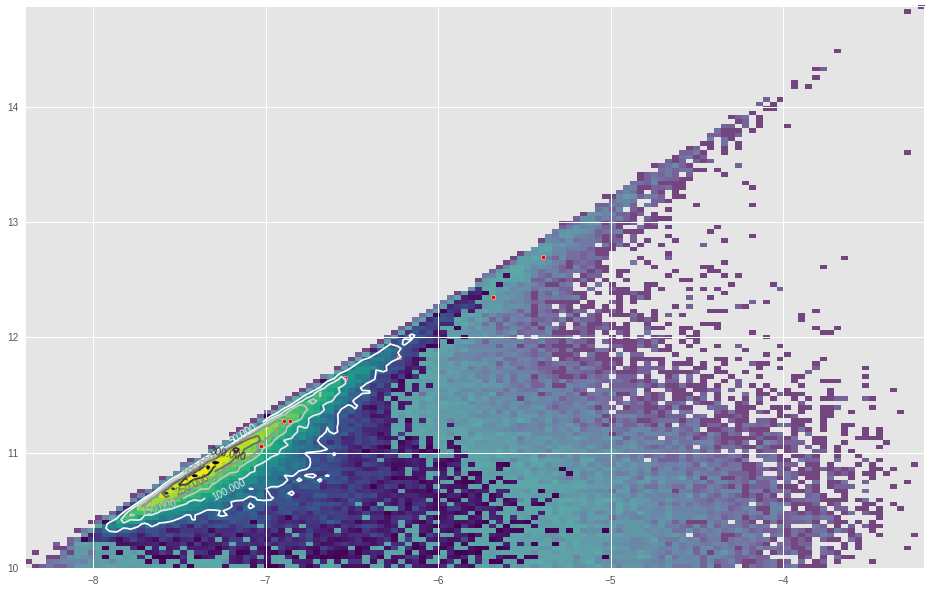

In [104]:
fig, ax = plt.subplots()

mask = inertia_data['host_gal'] == True
counts, xe, ye , img = ax.hist2d('log(prod_li)', 'log(mass)', data=inertia_data[mask], bins=128, norm=LogNorm(), cmap='viridis', cmin=1, alpha=0.7)

ax.hist2d('log(prod_li)', 'log(mass)', data=inertia_data[mask], bins=128, norm=LogNorm(), cmap='viridis', cmin=20)
CS = ax.contour(xe[1:], ye[1:], counts.T)
_ = ax.clabel(CS)

ax.scatter('log(prod_li)', 'log(mass)', data=inertia_data.loc[ids], c='red')

In [51]:
df = pd.DataFrame()
waiting = []
os.environ['OMP_NUM_THREADS'] = '2'

def process(halo_i, filename, df):
    tmp_df = pd.read_csv(filename, delim_whitespace=True, engine='c', dtype={'x': np.float64, 'y': np.float64, 'z': np.float64, 'id': int})
    tmp_df['halo'] = halo_i
    return df.append(tmp_df)

def load_halo(halo_i):
    
for i in ids:
    filename = 'data/halo_%i-00002' % i
        
    if os.path.isfile(filename):
        print('Found %s' % filename)
        df = process(i, filename, df)
    else:
        print('Queuing %s' % filename)
        gen_halo = sh.Command('dist/find_particles_in_halo')
        waiting.append((filename,
                        gen_halo('--output-number', 2, '--halo-i', i, '--verbose', 2, '--output', 'data/halo_%s-' % i, _env=os.environ,
                                 _bg=False
                                 ),
                        halo_i
                      ))
for filename, p, halo_i in waiting:
    print('Processing %s' % filename)
    p.wait()
    df = process(halo_i, filename, df)
del waiting

Found data/halo_156537-00002
Found data/halo_171572-00002
Found data/halo_37994-00002
Found data/halo_119957-00002
Found data/halo_150368-00002
Found data/halo_26226-00002
Found data/halo_111873-00002
Found data/halo_85789-00002
Found data/halo_74552-00002
Found data/halo_201204-00002


In [39]:
%%skip
dists = np.linspace(0, 1, 1000)
toKpc = RamsesOutput.info['unit_length'].express(C.kpc)

for halo_i in ids:
    data = df[df.halo == halo_i][['x' ,'y', 'z']].as_matrix()
    m1_3 = inertia_data.loc[halo_i, 'mass']**(1./3)
    data = data *1./ (1.*data.shape[0])**(1./3.)
    print(m1_3, data.shape)
    corrs = correlation.two_point(data, bins=dist)

    if inertia_data.loc[halo_i, 'vtheta_over_sigma']  > 1.5:
        c = 'r'
        l = '$v_\theta/\sigma > 1.5$'
    elif inertia_data.loc[halo_i, 'vtheta_over_sigma'] < 1.5:
        c = 'b'
        l = '$v_\theta/\sigma < 1.5$'
    else:
        c = 'grey'
        l = ''
        
    plt.plot(dist[:-1]*toKpc, corrs, label=('Halo %s' % halo_i) + l, c=c)
plt.yscale('symlog')
plt.xlabel('$d/m^{1/3}$ [$kpc/M_\odot^{1/3}$]')
plt.ylabel('Correlation')

Cell skipped.


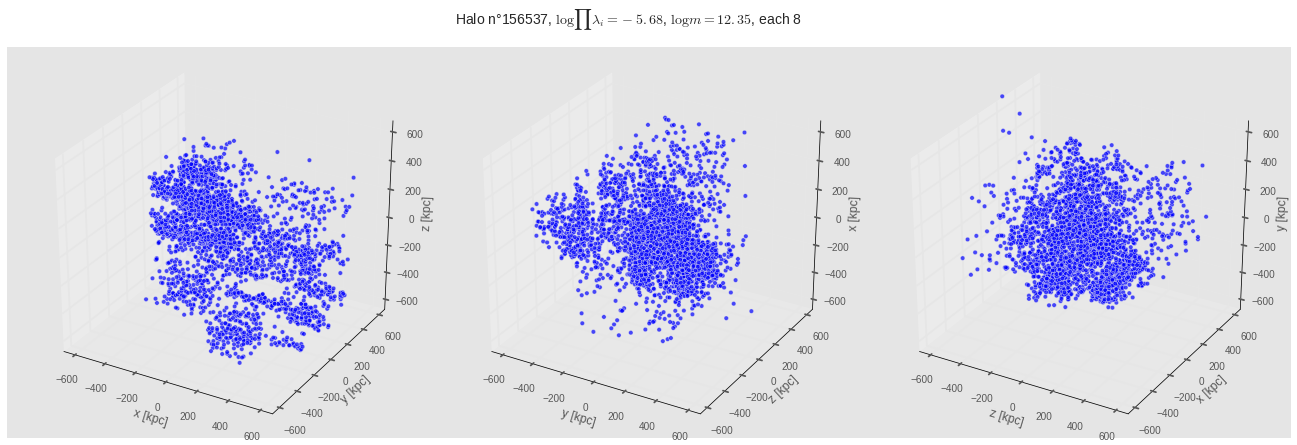

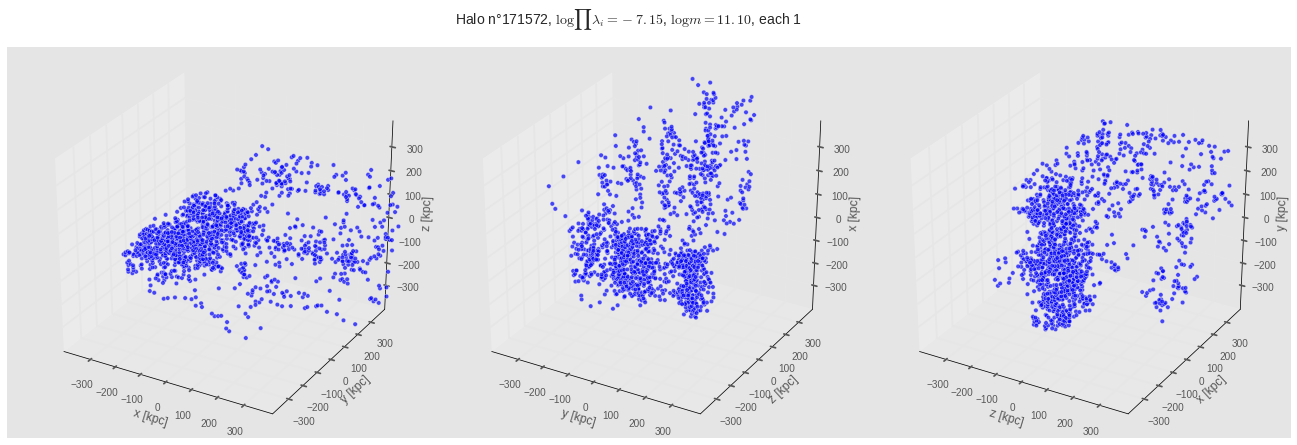

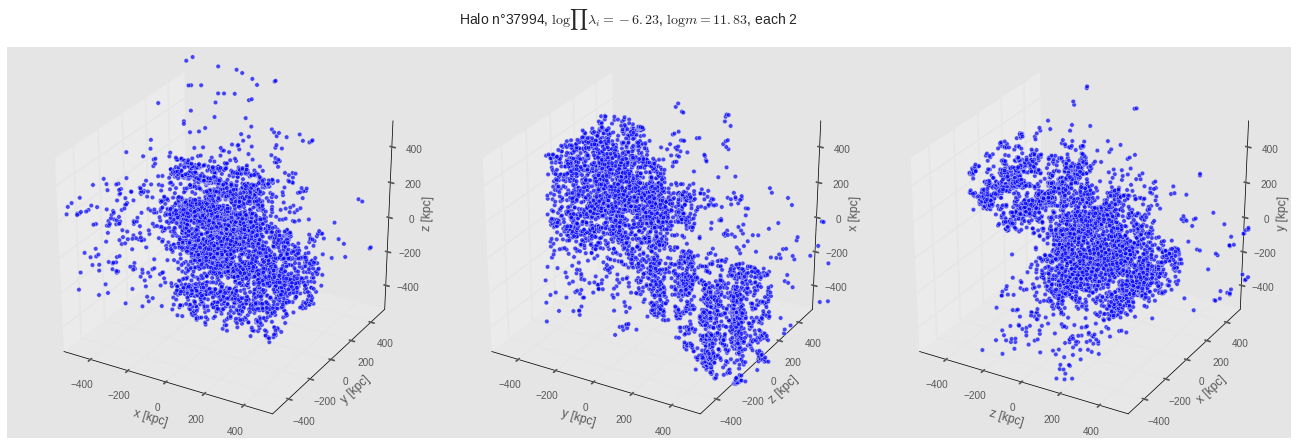

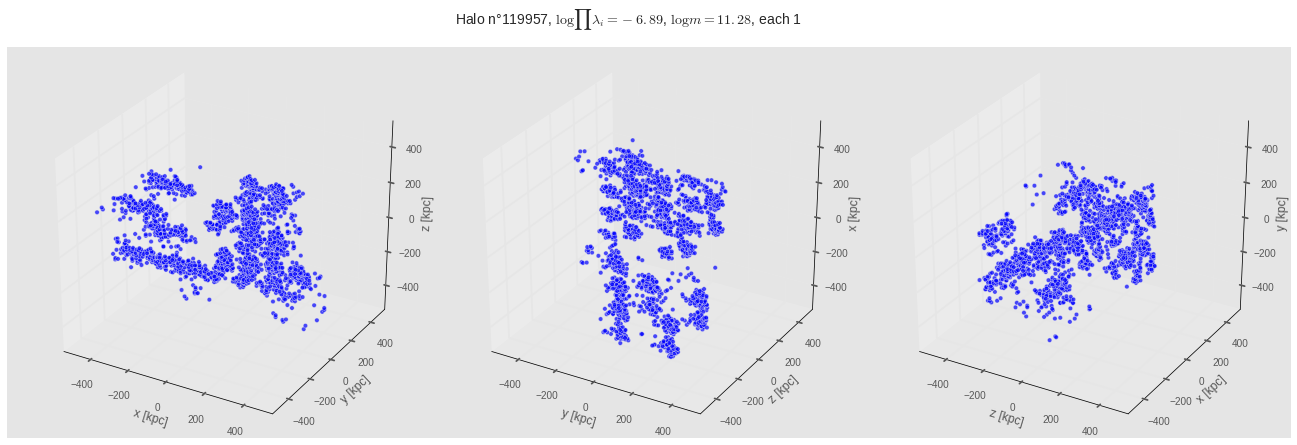

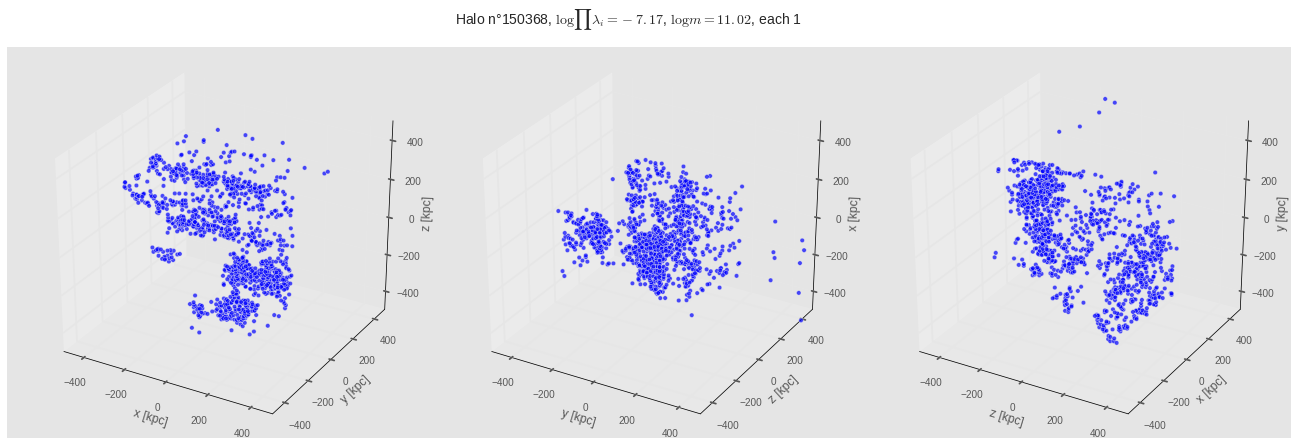

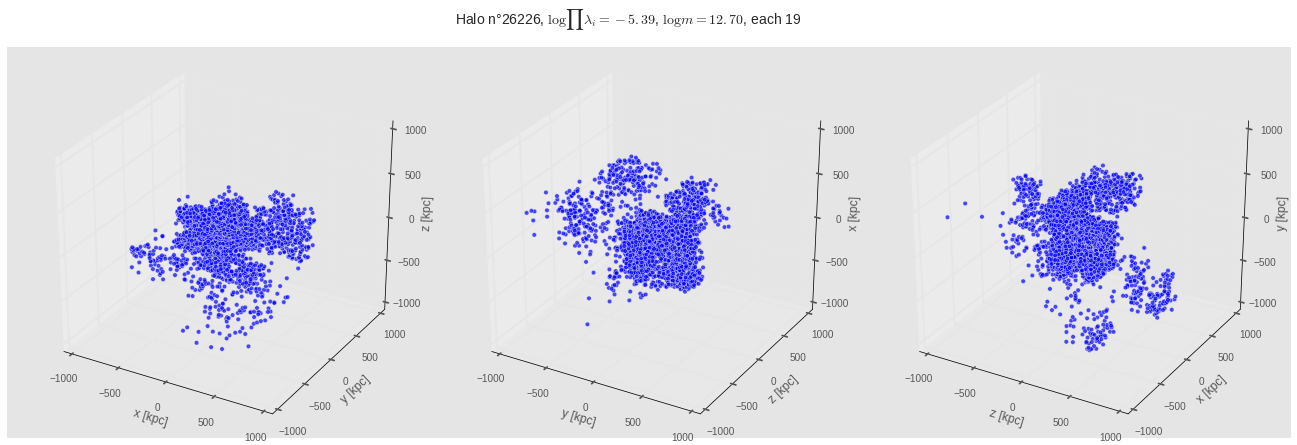

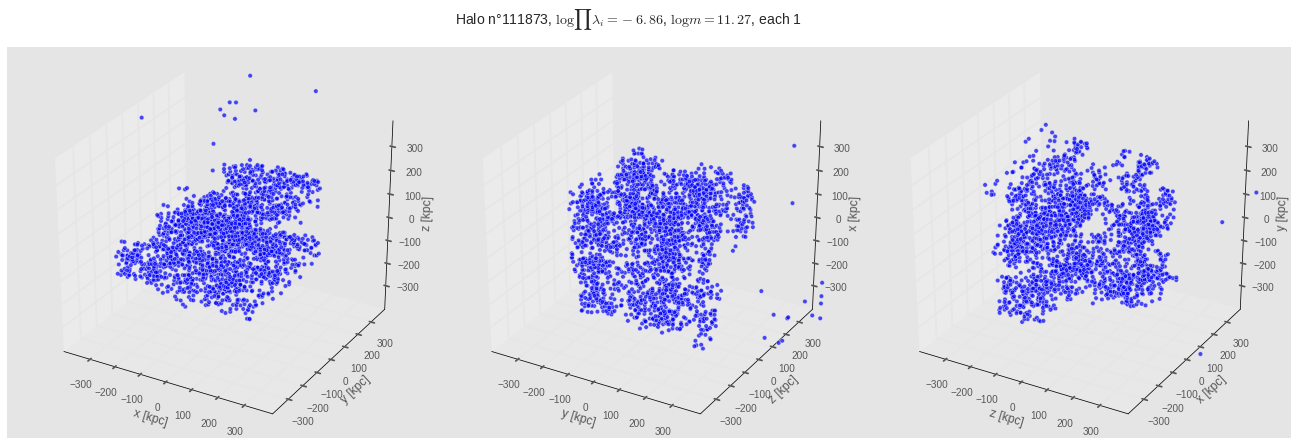

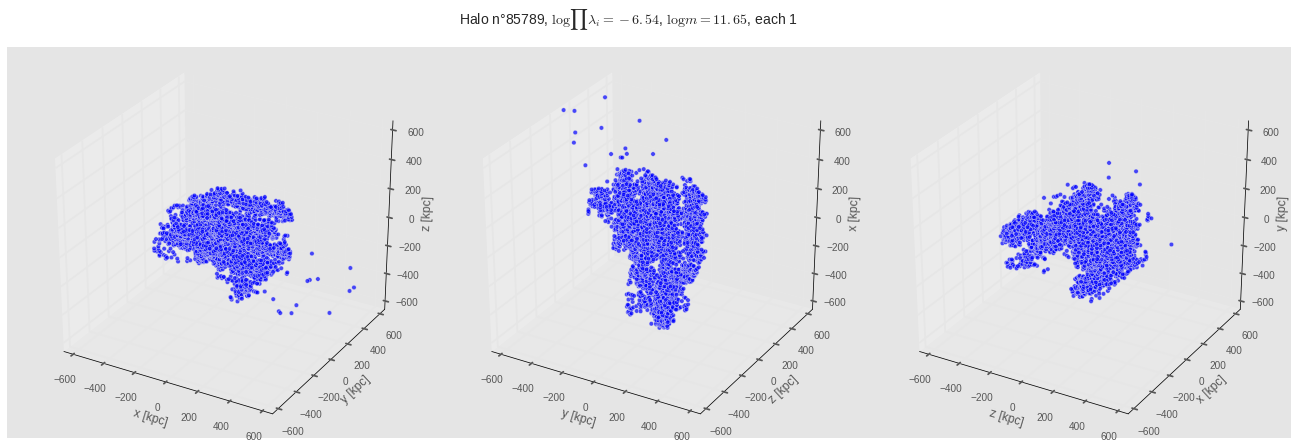

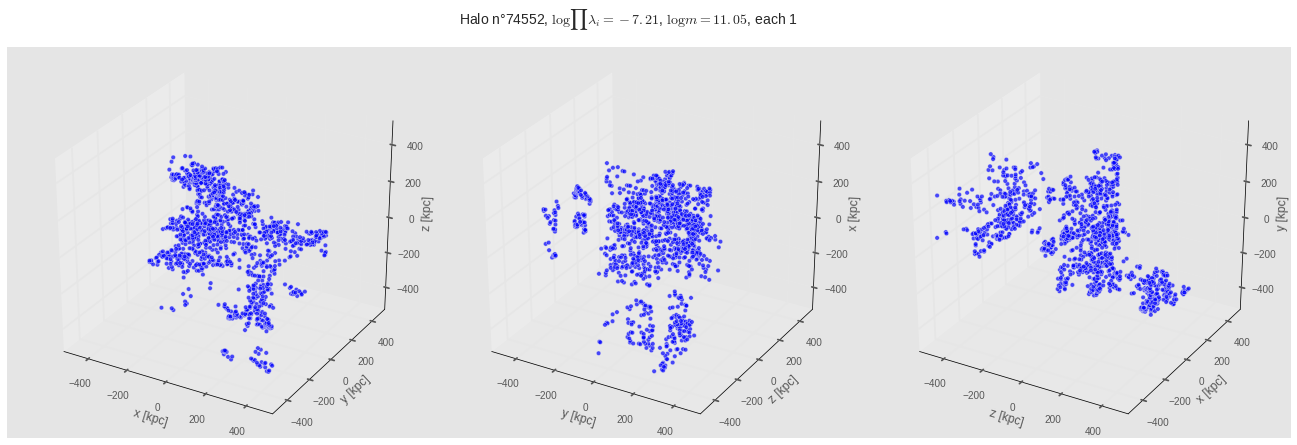

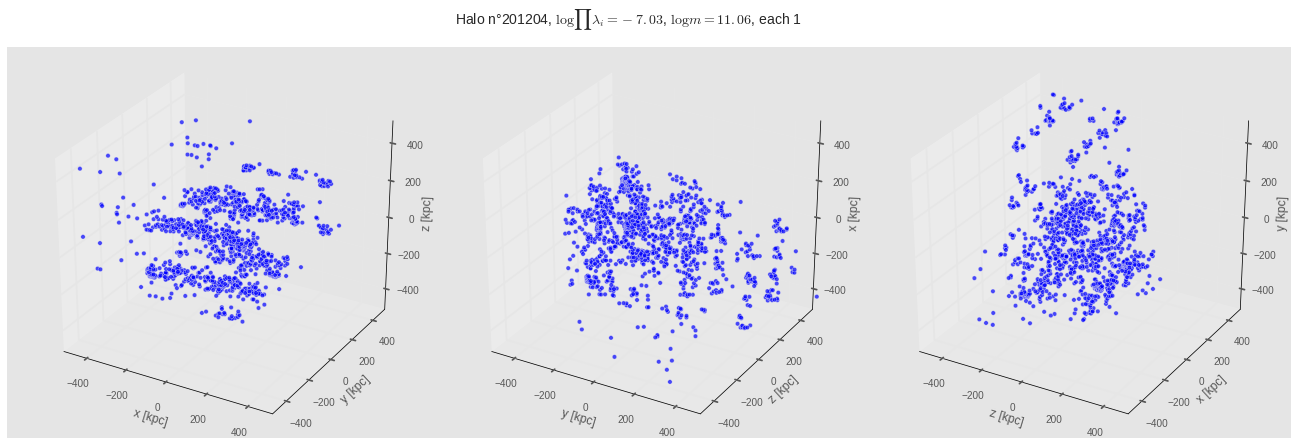

In [118]:
toKpc = RamsesOutput.info['unit_length'].express(C.kpc)
for i in ids:
    fig = plt.figure(figsize=(23, 23/3))
    
    mean = df.loc[df.halo==i, ['x', 'y', 'z']].mean()
    span = np.max(df[df.halo==i][['x', 'y', 'z']].max() - df[df.halo==i][['x', 'y', 'z']].min()) / 2
    
    corr = pd.DataFrame({'x': df.loc[df.halo == i, 'x'] - mean[0],
                         'y': df.loc[df.halo == i, 'y'] - mean[1],
                         'z': df.loc[df.halo == i, 'z'] - mean[2],
                        })
    # only plot 5000 points
    n = 3000
    each = max(1, corr['x'].size // n)
    
    for j, (x,y,z) in enumerate([['x', 'y', 'z'], ['y', 'z', 'x'], ['z', 'x', 'y']]):
        ax = fig.add_subplot(1,3,j+1, projection='3d')
        
        ax.scatter3D(corr[x][::each]*toKpc, corr[y][::each]*toKpc, corr[z][::each]*toKpc, alpha=0.7)
        fig.suptitle(u'Halo n°%i, $\log \prod \lambda_i = %.2f$, $\log m = %.2f$, each %i' % (i, inertia_data.loc[i, 'log(prod_li)'], inertia_data.loc[i, 'log(mass)'], each), fontsize=14)
        
        ax.set_xlabel('%s [kpc]' % x)
        ax.set_ylabel('%s [kpc]' % y)
        ax.set_zlabel('%s [kpc]' % z)
        
        ax.set_xlim(-span*toKpc, span*toKpc)
        ax.set_ylim(-span*toKpc, span*toKpc)
        ax.set_zlim(-span*toKpc, span*toKpc)
    plt.subplots_adjust(wspace=0, hspace=0)

# Wavelet academy

In [150]:
halo_i = 7
inertia_data.loc[halo_i:halo_i]

mass         x         y        z        xx       xy       xz  \
id                                                                           
7.0  1.408374e+12  0.038019  0.060522  0.03694  0.000061  0.00001  0.00001   

           yy        yz        zz        ...         hlevel  prolateness  \
id                                       ...                               
7.0  0.000112 -0.000007  0.000124        ...              1     1.259263   

     log(prolateness)  oblateness  log(oblateness)       prod_li  \
id                                                                 
7.0          0.100117    1.440679         0.158567  9.102841e-07   

     log(prod_li)  vtheta_over_sigma   galaxy_type  log(mass/prod_li)  
id                                                                     
7.0     -6.040823           0.774053  intermediate          18.189541  

[1 rows x 30 columns]

In [156]:
#df = pd.DataFrame(columns=df.columns)

In [158]:
if halo_i not in np.unique(df.halo.as_matrix()):
    print('Loading', halo_i)
    df = process(halo_i, 'tmp00002', df)

('Loading', 7)


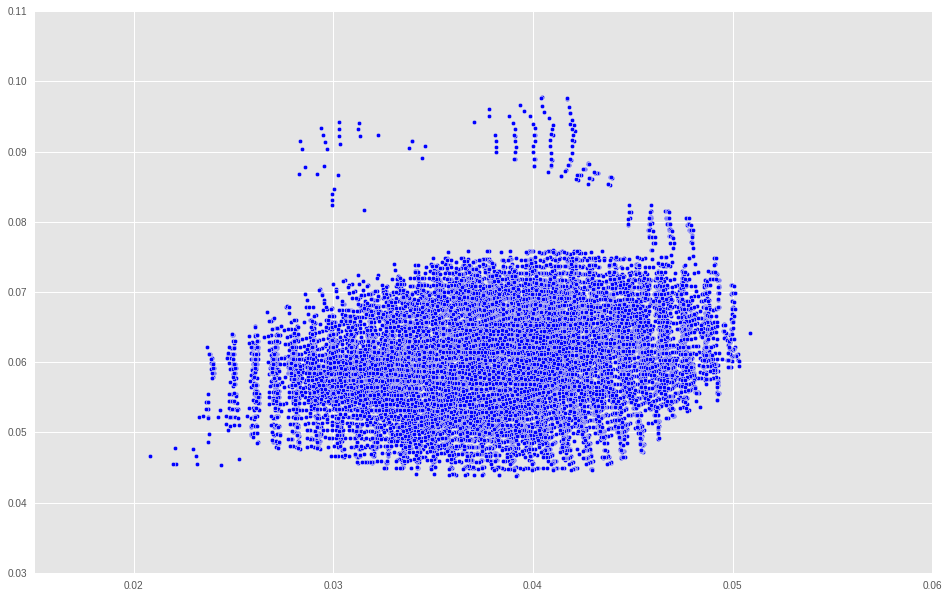

In [159]:
plt.scatter('x', 'y', data=df[df.halo == halo_i])

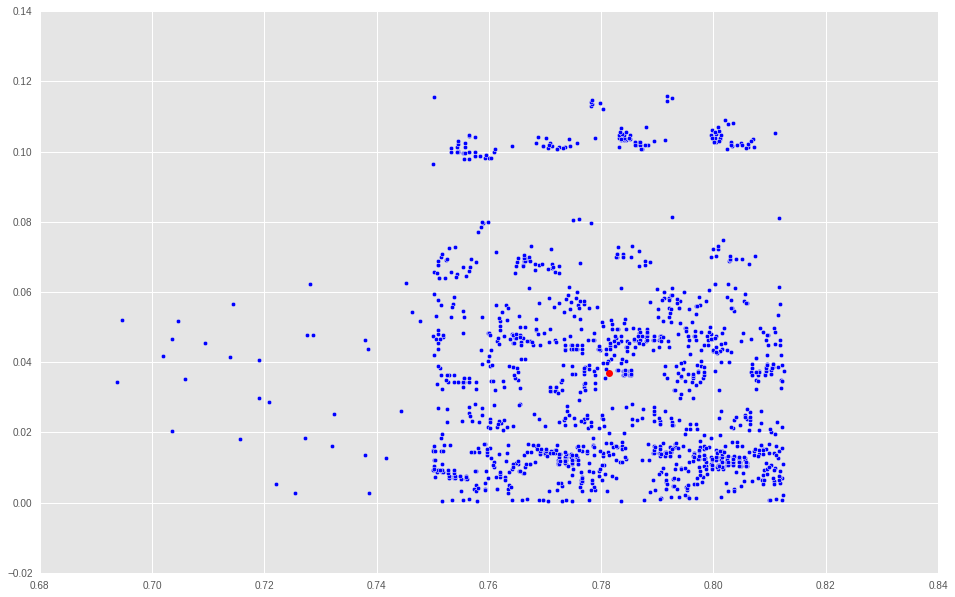

In [148]:
ax = plt.gca()
#sns.kdeplot(df[df.halo == halo_i]['x'], df[df.halo == halo_i]['y'], ax=ax)
ax.scatter('x', 'y', data=df[df.halo == halo_i])

center_of_mass = df[df.halo == halo_i][['x', 'y']].mean()
ax.plot('x', 'y', 'ro', data=center_of_mass)

!mkdir /home/cadiou/plots/output_00002/ -p
plt.savefig('/home/cadiou/plots/output_00002/%s.png' % halo_i)

In [88]:
df[df.halo == halo_i]

id         x         y         z   halo
0      110048085  0.037932  0.412635  0.474605  26226
1      110048236  0.031513  0.407261  0.477310  26226
2      110048319  0.003756  0.406387  0.476035  26226
3      110048714  0.048709  0.407749  0.477864  26226
4      110048862  0.049011  0.410495  0.445881  26226
5      110049502  0.014703  0.314090  0.468213  26226
6      110052038  0.022029  0.380897  0.445746  26226
7      110052050  0.006622  0.381554  0.478722  26226
8      110052093  0.056385  0.414289  0.447276  26226
9      110052104  0.037544  0.412977  0.477928  26226
10     110052515  0.042618  0.377649  0.473301  26226
11     110054026  0.010119  0.413639  0.440606  26226
12     110054554  0.057392  0.412863  0.473516  26226
13     110081458  0.032130  0.346829  0.473408  26226
14     110084406  0.008866  0.408923  0.452575  26226
15     110084418  0.022880  0.406469  0.481980  26226
16     110084778  0.011615  0.410068  0.452814  26226
17     110084794  0.042670  0.377380  0.450403  26226
18     110085019  0.014950  0.409769  0.450238  26226
19     110085035  0.042728  0.377844  0.480782  26226
20     110085403  0.029477  0.406620  0.481560  26226
21     110085429  0.004326  0.312435  0.470372  26226
22     110085444  0.028846  0.377012  0.483860  26226
23     110085487  0.002972  0.313750  0.470328  26226
24     110085502  0.060684  0.380225  0.481827  26226
25     110085518  0.027562  0.379458  0.482573  26226
26     110085550  0.061851  0.379029  0.482755  26226
27     110085566  0.060634  0.380179  0.482801  26226
28     110085598  0.048108  0.410943  0.450165  26226
29     110085726  0.056896  0.381495  0.479987  26226
...          ...       ...       ...       ...    ...
59470  963693088 -0.004494  0.407740  0.500062  26226
59471  963693096 -0.023414  0.377424  0.500081  26226
59472  963693104 -0.022255  0.378480  0.500072  26226
59473  963693112 -0.037218  0.392541  0.500033  26226
59474  963693119 -0.021283  0.378544  0.500046  26226
59475  963693127 -0.020391  0.378529  0.500074  26226
59476  963693135 -0.035972  0.392587  0.500036  26226
59477  963693143 -0.019401  0.376700  0.500061  26226
59478  963693151 -0.018912  0.409066  0.500051  26226
59479  963693159 -0.017466  0.377499  0.500064  26226
59480  963693167 -0.017232  0.409847  0.500065  26226
59481  963693175 -0.021278  0.425855  0.500016  26226
59482  963693183 -0.000039  0.396007  0.500069  26226
59483  963693243 -0.027643  0.384259  0.500058  26226
59484  963693251 -0.012907  0.429818  0.500013  26226
59485  963693265 -0.029761  0.385180  0.500044  26226
59486  963693273 -0.014765  0.384785  0.500099  26226
59487  963693281 -0.028638  0.385217  0.500064  26226
59488  963693295 -0.010553  0.401329  0.500065  26226
59489  963693352 -0.010688  0.402915  0.500068  26226
59490  963693360 -0.024241  0.387097  0.500119  26226
59491  963693368 -0.009555  0.419033  0.500030  26226
59492  963693376 -0.009011  0.404130  0.500062  26226
59493  963693392 -0.009883  0.404320  0.500061  26226
59494  963693400 -0.024424  0.389469  0.500060  26226
59495  963693408 -0.023581  0.390414  0.500081  26226
59496  963693475 -0.033040  0.400276  0.500035  26226
59497  963693489 -0.038670  0.389137  0.500033  26226
59498  963693504 -0.004357  0.405906  0.500083  26226
59499  963693518 -0.003594  0.404165  0.500082  26226

[59500 rows x 5 columns]

In [89]:
import pywt

def coef_pyramid_plot(coefs, first=0, scale='uniform', ax=None):
    """
    Parameters
    ----------
    coefs : array-like
        Wavelet Coefficients. Expects an iterable in order Cdn, Cdn-1, ...,
        Cd1, Cd0.
    first : int, optional
        The first level to plot.
    scale : str {'uniform', 'level'}, optional
        Scale the coefficients using the same scale or independently by
        level.
    ax : Axes, optional
        Matplotlib Axes instance

    Returns
    -------
    Figure : Matplotlib figure instance
        Either the parent figure of `ax` or a new pyplot.Figure instance if
        `ax` is None.
    """

    if ax is None:
        import matplotlib.pyplot as plt
        fig = plt.figure()
        ax = fig.add_subplot(111)
    else:
        fig = ax.figure

    n_levels = len(coefs)
    n = 2**(n_levels - 1) # assumes periodic

    if scale == 'uniform':
        biggest = [np.max(np.abs(np.hstack(coefs)))] * n_levels
    else:
        # multiply by 2 so the highest bars only take up .5
        biggest = [np.max(np.abs(i))*2 for i in coefs]

    for i in range(first,n_levels):
        x = np.linspace(2**(n_levels - 2 - i), n - 2**(n_levels - 2 - i), 2**i)
        ymin = n_levels - i - 1 + first
        yheight = coefs[i]/biggest[i]
        ymax = yheight + ymin
        ax.vlines(x, ymin, ymax, linewidth=1.1)

    ax.set_xlim(0,n)
    ax.set_ylim(first - 1, n_levels)
    ax.yaxis.set_ticks(np.arange(n_levels-1,first-1,-1))
    ax.yaxis.set_ticklabels(np.arange(first,n_levels))
    ax.tick_params(top=False, right=False, direction='out', pad=6)
    ax.set_ylabel("Levels", fontsize=14)
    ax.grid(True, alpha=.85, color='white', axis='y', linestyle='-')
    ax.set_title('Wavelet Detail Coefficients', fontsize=16,
            position=(.5,1.05))
    fig.subplots_adjust(top=.89)

    return fig

In [145]:
bin_count, bin_edges = np.histogramdd(df[df.halo == halo_i][['x', 'y']].as_matrix(), bins=128)
(cA, (cH, cV, cD)) = pywt.dwt2(bin_count, 'db8', mode='per')
cA
#fig = coef_pyramid_plot(true_coefs[1:], scale='uniform')

array([[ -4.25942960e-02,   1.00520134e-01,  -2.18491492e-01, ...,
         -8.87365986e-02,  -2.75908111e-03,   1.40468954e-02],
       [  2.44553052e-01,  -5.31782370e-01,   1.08321093e+00, ...,
          1.82377710e-01,   1.68764775e-02,  -8.45940673e-02],
       [  1.25747923e-01,  -2.98387046e-01,   5.95517736e-01, ...,
          9.79151167e-02,   6.30682629e-03,  -3.83819711e-02],
       ..., 
       [  2.76208756e-02,  -3.87075362e-02,   2.22608780e-02, ...,
         -5.42244449e-02,   1.05341265e+00,   1.57051402e-01],
       [  6.62717938e-03,  -1.79259004e-02,   2.90860347e-02, ...,
         -1.95729474e-02,   2.47895481e-01,   1.93648109e-02],
       [  1.44445708e-02,  -2.56456397e-02,   3.46492254e-02, ...,
          4.02256786e-02,   1.06059038e-03,  -5.24573379e-03]])

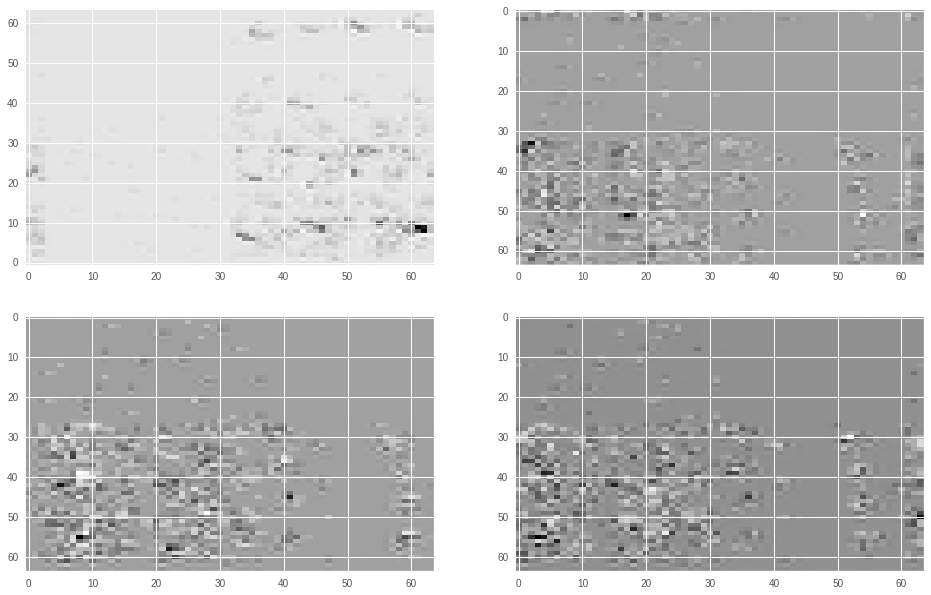

In [146]:
fig = plt.figure()
ax = fig.add_subplot(221)
ax.set_title('')
ax.imshow(cA.T, interpolation='none', aspect='auto', origin='lower')

ax = fig.add_subplot(222)
ax.imshow(cV, interpolation='none', aspect='auto')

ax = fig.add_subplot(223)
ax.imshow(cH, interpolation='none', aspect='auto')

ax = fig.add_subplot(224)
ax.imshow(cD, interpolation='none', aspect='auto')

In [147]:
halo_i

7